## **BIG DATA ANALYSIS**

**INSTRUCTIONS:** PERFORM ANALYSIS ON A LARGE DATASET USING TOOLS LIKE PYSPARK OR DASK TO DEMONSTRATE SCALABILITY.

1 - Install dependencies

In [ ]:
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# Install PySpark and findspark
!pip install -q pyspark==3.3.2 findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.3.2 which is incompatible.


In [ ]:
# Dask and distributed
!pip install -q "dask[complete]" distributed --quiet
!pip install -q fastparquet fsspec --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:00


In [ ]:
# Helpful utils
!pip install -q matplotlib pandas --quiet

2 - PySpark setup

In [ ]:
import os
import findspark


# If you installed spark via pip, findspark can initialize
findspark.init()


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year, month, sum as spark_sum, count as spark_count, desc, when
from pyspark.sql import functions as F


spark = SparkSession.builder \
.appName('BigDataRetailAnalysis') \
.config('spark.driver.memory', '4g') \
.config('spark.sql.shuffle.partitions', '8') \
.getOrCreate()


print('Spark version:', spark.version)

Spark version: 3.3.2


3 - Load CSV into PySpark DataFrame

In [ ]:
# uploaded the file
csv_path = '/content/retail_sales_dataset.csv'

In [ ]:
# Example schema inference; for larger files it is faster to provide schema
sdf = spark.read.option('header', 'true').option('inferSchema', 'true').csv(csv_path)
sdf.printSchema()
print('Rows:', sdf.count())

root
 |-- Transaction ID: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price per Unit: integer (nullable = true)
 |-- Total Amount: integer (nullable = true)

Rows: 1000


4 - Quick cleaning & type fixes

In [ ]:
# Common columns in retail_sales_dataset: order_id, order_date, product_id, category, region, qty, price, revenue
# Adapt column names if needed.

cols = [c.lower() for c in sdf.columns]
# rename columns to lowercase for consistency
for old, new in zip(sdf.columns, cols):
    if old != new:
        sdf = sdf.withColumnRenamed(old, new)


# Try to cast numeric columns
for c in ['qty', 'quantity', 'price', 'revenue', 'sales']:
    if c in sdf.columns:
        sdf = sdf.withColumn(c, col(c).cast('double'))


# Parse date
date_col = None
for candidate in ['order_date', 'date', 'transaction_date']:
    if candidate in sdf.columns:
        date_col = candidate
        break


if date_col:
    sdf = sdf.withColumn('order_date', to_date(col(date_col)))
else:
    print('No obvious date column found. Check your column names:', sdf.columns)


# Quick null and duplicate checks
print('Columns:', sdf.columns)
print('Null counts sample:')
sdf.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in sdf.columns]).show()


# Drop duplicates on order id if exists
if 'order_id' in sdf.columns:
    before = sdf.count()
    sdf = sdf.dropDuplicates(['order_id'])
    after = sdf.count()
    print(f'dropped {before-after} duplicate order_id rows')


# Cache if you will reuse this DataFrame multiple times
sdf.cache()

Columns: ['transaction id', 'date', 'customer id', 'gender', 'age', 'product category', 'quantity', 'price per unit', 'total amount', 'order_date']
Null counts sample:
+--------------+----+-----------+------+---+----------------+--------+--------------+------------+----------+
|transaction id|date|customer id|gender|age|product category|quantity|price per unit|total amount|order_date|
+--------------+----+-----------+------+---+----------------+--------+--------------+------------+----------+
|             0|   0|          0|     0|  0|               0|       0|             0|           0|         0|
+--------------+----+-----------+------+---+----------------+--------+--------------+------------+----------+



DataFrame[transaction id: int, date: timestamp, customer id: string, gender: string, age: int, product category: string, quantity: double, price per unit: int, total amount: int, order_date: date]

5 - Aggregations & Insights

In [ ]:
# 1) Top 10 products by revenue
# Using 'product category' as product_id and 'total amount' as revenue, 'quantity' as qty
if 'product category' in sdf.columns and 'total amount' in sdf.columns:
    top_products = sdf.groupBy('product category').agg(
        F.sum('total amount').alias('total_revenue'),
        F.sum('quantity').alias('total_quantity')
    ).orderBy(desc('total_revenue')).limit(10)
    print("Top 10 products by revenue:")
    top_products.show(truncate=False)
else:
    print("Columns 'product category' or 'total amount' not found for Top Products by Revenue analysis.")

Top 10 products by revenue:
+----------------+-------------+--------------+
|product category|total_revenue|total_quantity|
+----------------+-------------+--------------+
|Electronics     |156905       |849.0         |
|Clothing        |155580       |894.0         |
|Beauty          |143515       |771.0         |
+----------------+-------------+--------------+



In [ ]:
# 2) Sales by gender and month (instead of region, as 'region' column is missing)
if 'gender' in sdf.columns and 'order_date' in sdf.columns and 'total amount' in sdf.columns:
    sales_by_gender_month = sdf.withColumn('year', year('order_date')).withColumn('month', month('order_date')) \
        .groupBy('gender', 'year', 'month') \
        .agg(F.round(F.sum('total amount'), 2).alias('monthly_revenue')) \
        .orderBy('gender', 'year', 'month')
    print("\nSales by Gender and Month:")
    sales_by_gender_month.show(20, truncate=False)
else:
    print("Columns 'gender', 'order_date' or 'total amount' not found for Sales by Gender and Month analysis.")


Sales by Gender and Month:
+------+----+-----+---------------+
|gender|year|month|monthly_revenue|
+------+----+-----+---------------+
|Female|2023|1    |24725          |
|Female|2023|2    |14395          |
|Female|2023|3    |13320          |
|Female|2023|4    |17300          |
|Female|2023|5    |23930          |
|Female|2023|6    |16875          |
|Female|2023|7    |16885          |
|Female|2023|8    |22080          |
|Female|2023|9    |16535          |
|Female|2023|10   |26600          |
|Female|2023|11   |14890          |
|Female|2023|12   |25305          |
|Male  |2023|1    |10725          |
|Male  |2023|2    |29665          |
|Male  |2023|3    |15670          |
|Male  |2023|4    |16570          |
|Male  |2023|5    |29220          |
|Male  |2023|6    |19840          |
|Male  |2023|7    |18580          |
|Male  |2023|8    |14880          |
+------+----+-----+---------------+
only showing top 20 rows



In [ ]:
# 3) Trend: daily revenue (sample)
# Using 'total amount' as revenue
if 'order_date' in sdf.columns and 'total amount' in sdf.columns:
    daily_rev = sdf.groupBy('order_date').agg(F.round(F.sum('total amount'), 2).alias('daily_revenue')) \
        .orderBy('order_date')
    print("\nDaily Revenue Trend (sample):")
    daily_rev.show(10)
else:
    print("Columns 'order_date' or 'total amount' not found for Daily Revenue Trend analysis.")


Daily Revenue Trend (sample):
+----------+-------------+
|order_date|daily_revenue|
+----------+-------------+
|2023-01-01|         3600|
|2023-01-02|         1765|
|2023-01-03|          600|
|2023-01-04|         1240|
|2023-01-05|         1100|
|2023-01-06|          620|
|2023-01-07|          150|
|2023-01-08|          625|
|2023-01-09|          200|
|2023-01-10|          230|
+----------+-------------+
only showing top 10 rows



In [ ]:
# Save a small result for download
out_path = '/content/top_products_by_revenue.parquet'
if 'product category' in sdf.columns and 'total amount' in sdf.columns:
    # Ensure top_products DataFrame is available to save
    if 'top_products' in locals(): # Check if top_products was successfully generated
        top_products.write.mode('overwrite').parquet(out_path)
        print('\nWrote top products by category to', out_path)
    else:
        print("\nTop products DataFrame not available to save.")
else:
    print("\nColumns 'product category' or 'total amount' not found for saving top products.")


Wrote top products by category to /content/top_products_by_revenue.parquet


6 - Window functions & cohort-like analysis

In [ ]:
from pyspark.sql.window import Window


# Example: For each product show month-over-month revenue growth
if 'product category' in sdf.columns and 'order_date' in sdf.columns and 'total amount' in sdf.columns:
    prod_month = sdf.withColumn('year', year('order_date')).withColumn('month', month('order_date')) \
        .groupBy('product category', 'year', 'month').agg(F.sum('total amount').alias('rev'))
    w = Window.partitionBy('product category').orderBy('year', 'month')
    prod_month = prod_month.withColumn('prev_rev', F.lag('rev').over(w)) \
        .withColumn('mom_change', (col('rev') - col('prev_rev')) / col('prev_rev'))
    prod_month.filter(col('prev_rev').isNotNull()).show(10)
else:
    print("Columns 'product category', 'order_date' or 'total amount' not found for Month-over-Month Revenue Growth analysis.")

+----------------+----+-----+-----+--------+--------------------+
|product category|year|month|  rev|prev_rev|          mom_change|
+----------------+----+-----+-----+--------+--------------------+
|          Beauty|2023|    2|14035|   12430| 0.12912308930008046|
|          Beauty|2023|    3|10545|   14035|-0.24866405415033843|
|          Beauty|2023|    4|11905|   10545|  0.1289710763394974|
|          Beauty|2023|    5|12450|   11905| 0.04577908441831163|
|          Beauty|2023|    6|10995|   12450|-0.11686746987951807|
|          Beauty|2023|    7|16090|   10995|  0.4633924511141428|
|          Beauty|2023|    8| 9790|   16090| -0.3915475450590429|
|          Beauty|2023|    9| 6320|    9790|-0.35444330949948927|
|          Beauty|2023|   10|15355|    6320|  1.4295886075949367|
|          Beauty|2023|   11| 9700|   15355| -0.3682839465971996|
+----------------+----+-----+-----+--------+--------------------+
only showing top 10 rows



7 - Performance tips used here

In [ ]:
# repartition
sdf = sdf.repartition(8)
print('Repartitioned to', sdf.rdd.getNumPartitions())

Repartitioned to 8


8 - Dask alternative pipeline

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster


# Start a local cluster (in Colab this is limited). On a real cluster use dask-ssh or cloud provider
cluster = LocalCluster(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client = Client(cluster)
print(client)


# Read CSV with Dask. Parse the 'Date' column from the raw CSV.
df_path = '/content/retail_sales_dataset.csv' # change if needed
ddf = dd.read_csv(df_path, assume_missing=True, parse_dates=['Date']) # Changed 'order_date' to 'Date'

# Lowercase column names to match PySpark's processed SDF for consistency
ddf.columns = [c.lower() for c in ddf.columns]

# Create 'order_date' column from 'date' column, similar to PySpark's processing
# The 'date' column in ddf is already a datetime type because of parse_dates=['Date']
ddf['order_date'] = ddf['date'].dt.date

# Convert numeric columns (these are already lowercased from above step)
# Update the list of columns to explicitly match what's in the dataset and potentially numeric.
for c in ['quantity', 'price per unit', 'total amount', 'age']:
    if c in ddf.columns:
        ddf[c] = ddf[c].astype('float')

/usr/local/lib/python3.12/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41521 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42827
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:41521/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44161'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34981'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34625 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34625
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:41612
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34701 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34701
IN

<Client: 'tcp://127.0.0.1:42827' processes=2 threads=4, memory=3.73 GiB>


In [ ]:
# Quick checks
print('Dask partitions:', ddf.npartitions)
# Print head after all initial processing to show the correct state
print(ddf.head())

Dask partitions: 1
   transaction id       date customer id  gender   age product category  \
0             1.0 2023-11-24     CUST001    Male  34.0           Beauty   
1             2.0 2023-02-27     CUST002  Female  26.0         Clothing   
2             3.0 2023-01-13     CUST003    Male  50.0      Electronics   
3             4.0 2023-05-21     CUST004    Male  37.0         Clothing   
4             5.0 2023-05-06     CUST005    Male  30.0           Beauty   

   quantity  price per unit  total amount order_date  
0       3.0            50.0         150.0 2023-11-24  
1       2.0           500.0        1000.0 2023-02-27  
2       1.0            30.0          30.0 2023-01-13  
3       1.0           500.0         500.0 2023-05-21  
4       2.0            50.0         100.0 2023-05-06  


In [ ]:
# Example: groupby product category to compute total revenue (Dask)
# Using lowercased and consistent column names
if 'product category' in ddf.columns and 'total amount' in ddf.columns:
    dask_top = ddf.groupby('product category')['total amount'].sum().nlargest(10).compute()
    print('Top products by revenue (Dask):')
    print(dask_top)
else:
    print("Columns 'product category' or 'total amount' not found for Top Products by Revenue analysis.")

Top products by revenue (Dask):
product category
Electronics    156905.0
Clothing       155580.0
Beauty         143515.0
Name: total amount, dtype: float64


In [ ]:
# Time series resample (requires index by datetime)
# Using consistent 'order_date' and 'total amount'
if 'order_date' in ddf.columns and 'total amount' in ddf.columns:
    # Convert 'order_date' back to datetime if it was converted to date-only object
    # For Dask's set_index and resample, it's often better to have datetime objects
    ddf['order_date'] = dd.to_datetime(ddf['order_date'])
    ts = ddf.set_index('order_date', sorted=True) # Added sorted=True here
    monthly = ts['total amount'].resample('M').sum().compute()
    print(monthly.head())
else:
    print("Columns 'order_date' or 'total amount' not found for Time Series Resampling.")

/usr/local/lib/python3.12/dist-packages/dask/dataframe/tseries/resample.py:133: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resample = meta_nonempty(self.frame._meta).resample(self.rule, **self.kwargs)


order_date
2023-01-31    35450.0
2023-02-28    44060.0
2023-03-31    28990.0
2023-04-30    33870.0
2023-05-31    53150.0
Freq: ME, Name: total amount, dtype: float64


/usr/local/lib/python3.12/dist-packages/dask/dataframe/tseries/resample.py:67: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rule = pd.tseries.frequencies.to_offset(rule)


9 - Export Dask results and plotting

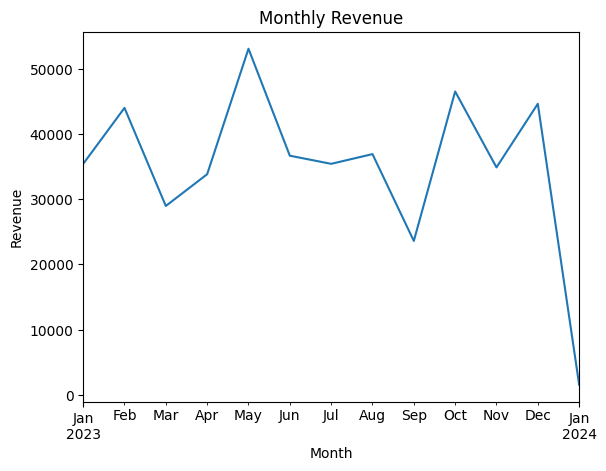

In [ ]:
import matplotlib.pyplot as plt


# simple plot of monthly revenue (use pandas series returned above)
if 'monthly' in locals():
    monthly.plot()
    plt.title('Monthly Revenue')
    plt.xlabel('Month')
    plt.ylabel('Revenue')
    plt.show()


# Save Dask to Parquet partitioned by region (if exists)
if 'region' in ddf.columns:
    ddf.to_parquet('/content/dask_parquet_by_region', engine='fastparquet', write_index=False)
    print('Saved Dask parquet to /content/dask_parquet_by_region')


10 - Short checklist for scaling to real big-data clusters

PySpark:

Use a multi-node Spark cluster (Dataproc, EMR, self-managed YARN/Mesos Kubernetes)

Tune executor memory, cores, and spark.sql.shuffle.partitions

Use predicate pushdown and partitioning when reading from Parquet/ORC

Store intermediate results to distributed storage (GCS/S3/HDFS)